<a href="https://colab.research.google.com/github/pavelkochkin1/pockets/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [4]:
df = pd.read_csv("data.csv")
df = df[df['tcp'] == 1].drop('tcp', axis=1)

In [5]:
df.target.value_counts()

0    120838
1     18165
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


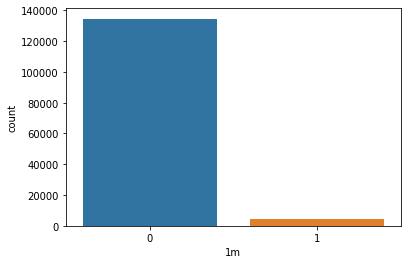

In [6]:
sns.countplot(df['1m'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


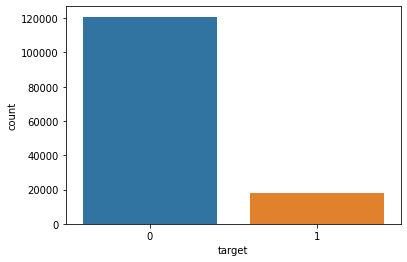

In [7]:
sns.countplot(df.target)

In [8]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.10, stratify=df['target'])
print(f"train shape: {train_df.shape} ; test_df: {test_df.shape}")

train shape: (125102, 3) ; test_df: (13901, 3)


In [9]:
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
import re

In [17]:
snowball = SnowballStemmer(language='english')
stop_words = stopwords.words('english')
RE = r'[\w]+'

def tokenize_host(sentence: str, remove_stop_words: bool = False):
    #tokens = re.findall(RE2, sentence)
    tokens = sentence.split(sep='.')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens


In [19]:
# example
tokenize_host(df.iloc[2]['host'])

['w-74721', 'fp', 'kaspersky-lab', 'com']

In [21]:
vectorizer = TfidfVectorizer(tokenizer=tokenize_host)
features = vectorizer.fit_transform(train_df['host'])

In [22]:
model = LogisticRegression(random_state=42, max_iter=300)
model.fit(features, train_df['target'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
test_features = vectorizer.transform(test_df['host'])
pred = model.predict(test_features)

In [24]:
r = recall_score(pred, test_df['target'])
p = precision_score(pred, test_df['target'])
f1 = f1_score(pred, test_df['target'])

print(f"recall: {r}\nprecision: {p}\nf1: {f1}")

recall: 0.5992160705536502
precision: 0.6730875068794716
f1: 0.634007257646449


# Pipeline

In [25]:
def tokenize(host: str):
    tokens = re.findall(r'[\w]+', host)
    #tokens = host.split(sep='.')
    tokens = [i for i in tokens if i not in string.punctuation]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [27]:
model_pipeline = Pipeline([
                           ('vectorizer', TfidfVectorizer(tokenizer=tokenize)),
                           ('model', LogisticRegression(random_state=42, max_iter=1000))
])

In [28]:
model_pipeline.fit(train_df['host'], train_df['target'])

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x7f191df07b90>,
                                 use_idf=True, vocabulary=None)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_

In [29]:
model_pipeline.predict(df['host']).sum()

13257

In [30]:
pred = model_pipeline.predict(test_df['host'])

r = recall_score(pred, test_df['target'])
p = precision_score(pred, test_df['target'])
f1 = f1_score(pred, test_df['target'])

print(f"recall: {r}\nprecision: {p}\nf1: {f1}")

recall: 0.6189710610932476
precision: 0.635663181067694
f1: 0.6272060819983709


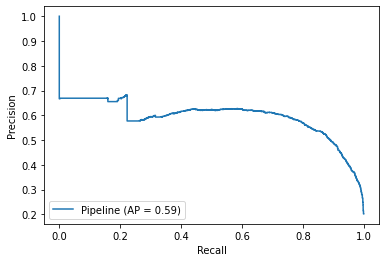

In [31]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df['target'], probas_pred=model_pipeline.predict_proba(test_df['host'])[:,1])
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["host"], y=test_df['target'])

In [42]:
print(np.where((rec > 0.632) & (prec > 0.62)))

(array([5830, 5831, 5832]),)


In [44]:
thresholds[5831]

0.504182989284498

In [45]:
def score(df, model, thresholds):
    pred = model.predict_proba(df['host'])[:,1] > thresholds

    r = recall_score(pred, df['target'])
    p = precision_score(pred, df['target'])
    f1 = f1_score(pred, df['target'])

    return (f"recall: {r}\nprecision: {p}\nf1: {f1}")

print(score(test_df, model_pipeline, thresholds[5831]))

recall: 0.6204103671706264
precision: 0.6323610346725371
f1: 0.6263286999182339


# grid search




In [49]:
params = {'n_estimators': [200,400,800], 'max_depth': [3,5,7]}
params = {'max_iter':[200,500], 'C': [0.1,1,10]}
gs_pipeline = Pipeline([
                        ('vectorizer', TfidfVectorizer(tokenizer=tokenize)),
                        ('model', 
                         GridSearchCV(
                             LogisticRegression(random_state=42),
                             param_grid=params,
                             cv=3,
                             verbose=4
                         ))
])

In [50]:
gs_pipeline.fit(train_df['host'], train_df['target'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=0.1, max_iter=200 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. C=0.1, max_iter=200, score=0.878, total=   3.1s
[CV] C=0.1, max_iter=200 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] ................. C=0.1, max_iter=200, score=0.878, total=   2.7s
[CV] C=0.1, max_iter=200 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s


[CV] ................. C=0.1, max_iter=200, score=0.877, total=   3.0s
[CV] C=0.1, max_iter=500 .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.8s remaining:    0.0s


[CV] ................. C=0.1, max_iter=500, score=0.878, total=   2.9s
[CV] C=0.1, max_iter=500 .............................................
[CV] ................. C=0.1, max_iter=500, score=0.878, total=   2.7s
[CV] C=0.1, max_iter=500 .............................................
[CV] ................. C=0.1, max_iter=500, score=0.877, total=   3.1s
[CV] C=1, max_iter=200 ...............................................
[CV] ................... C=1, max_iter=200, score=0.906, total=   4.6s
[CV] C=1, max_iter=200 ...............................................
[CV] ................... C=1, max_iter=200, score=0.905, total=   6.5s
[CV] C=1, max_iter=200 ...............................................
[CV] ................... C=1, max_iter=200, score=0.906, total=   6.1s
[CV] C=1, max_iter=500 ...............................................
[CV] ................... C=1, max_iter=500, score=0.906, total=   4.4s
[CV] C=1, max_iter=500 ...............................................
[CV] .

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=10, max_iter=200, score=0.908, total=   9.3s
[CV] C=10, max_iter=200 ..............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=10, max_iter=200, score=0.909, total=   9.1s
[CV] C=10, max_iter=200 ..............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=10, max_iter=200, score=0.909, total=   9.0s
[CV] C=10, max_iter=500 ..............................................
[CV] .................. C=10, max_iter=500, score=0.908, total=  13.1s
[CV] C=10, max_iter=500 ..............................................
[CV] .................. C=10, max_iter=500, score=0.909, total=  12.2s
[CV] C=10, max_iter=500 ..............................................
[CV] .................. C=10, max_iter=500, score=0.909, total=  12.7s


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.9min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1

In [51]:
gs_pipeline['model'].best_params_

{'C': 10, 'max_iter': 200}

# Best model

In [53]:
model_pipeline = Pipeline([
                           ('vectorizer', TfidfVectorizer(tokenizer=tokenize)),
                           ('model', LogisticRegression(max_iter=300, C=10))
])

model_pipeline.fit(train_df['host'], train_df['target'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x7f191df07b90>,
                                 use_idf=True, vocabulary=None)),
                ('model',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_i

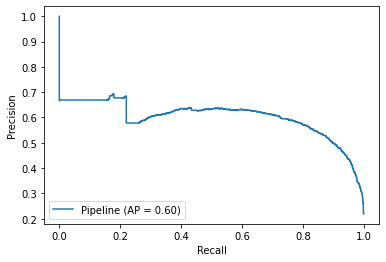

In [54]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df['target'], probas_pred=model_pipeline.predict_proba(test_df['host'])[:,1])
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["host"], y=test_df['target'])

In [62]:
print(np.where((rec > 0.614) & (prec > 0.63)))

(array([5294, 5295, 5296, 5297]),)


In [64]:
print(score(test_df, model_pipeline, thresholds[5296]))

recall: 0.6305084745762712
precision: 0.6141992294991745
f1: 0.6222470030666295


# saving Model

In [65]:
import joblib

joblib.dump(model_pipeline, 'basemodel.joblib')

['basemodel.joblib']

# Transformers

In [334]:
data = df.drop(['1m'], axis=1)
hosts = data.host.values
target = data.target.values
data.head()

,host,target
0,api.youla.io,1
1,favicon.yandex.net,0
2,w-74721.fp.kaspersky-labs.com,0
3,questtime.net,1
4,passport-authproxy.taxi.yandex.net,0


In [336]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 37.4 MB/s 
     |████████████████████████████████| 895 kB 47.0 MB/s 
     |████████████████████████████████| 636 kB 56.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [339]:
from transformers import BertTokenizer
# using the low level BERT for our task
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

print('Original:', hosts[0])
print('Tokenized:', tokenizer.tokenize(hosts[0]))
print('Token IDs:', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(hosts[0])))

Original: api.youla.io
Tokenized: ['api', '.', 'you', '##la', '.', 'io']
Token IDs: [17928, 1012, 2017, 2721, 1012, 22834]


In [340]:
input_ids = []
for host in hosts:
    encoded_host = tokenizer.encode(
        host,
        add_special_tokens = True,

    )

    input_ids.append(encoded_host)

In [341]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 128

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN , truncating="post", padding="post")

In [343]:
attention_masks = []

for host in input_ids:
    
    # Generating attention mask for sentences.
    #   - when there is 0 present as token id we are going to set mask as 0.
    #   - we are going to set mask 1 for all non-zero positive input id.
    att_mask = [int(token_id > 0) for token_id in host]
    
   
    attention_masks.append(att_mask)


### Training model

In [346]:
import torch

In [348]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, target, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, target,test_size=0.2)


In [349]:
#changing the numpy arrays into tensors for working on GPU. 
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Deciding the batch size for training.

batch_size = 32

#DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for our validation(test) set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [350]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,   
    output_attentions = False,
    output_hidden_states = False,
)

# Running the model on GPU.
model.cuda()


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

RuntimeError: ignored